In [507]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import nibabel as nib

from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import rand_score
from nibabel.nifti1 import Nifti1Image


def load_data(hemisphere):
    X = pd.read_csv('https://raw.githubusercontent.com/JonahKember/hippocampus_clustering/main/' + hemisphere + '_nmf_input.csv')
    X = X.to_numpy()
    return(X)

def run_nmf(X,k):
    
    '''1. Rescale columns of X to the interval [0,1].
    2. Run Non-Negative matrix factorization on X with k components.'''

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    model = NMF(n_components = k, init = 'random', max_iter = 10000)
    model.fit_transform(X)
    
    W = model.transform(X)
    clusters = np.argmax(W,1)

    return(clusters, model)

def get_nmf_similarity(X, k, n_shuffle = 5):
    
    '''Calculate the stability of NMF components. 
    1. Randomly split the matrix X in half n_shuffle times.
    2. Run NMF on each half (with k components).
    3. Calculate the adjusted Rand index between the clusters output from each half.'''

    rand_indices = np.zeros(n_shuffle)

    for split in range(n_shuffle):

        # Generate randomly shuffled indices (seed set for reproducibility).
        np.random.seed(split)
        idx = np.split(np.random.permutation(X.shape[1]),2)

        # Get NMF clusters for each split.
        clust_1 = run_nmf(X[:,idx[0]],k)[0]
        clust_2 = run_nmf(X[:,idx[1]],k)[0]

        # Calculate the adjusted Rand index.
        rand_indices[split] = adjusted_rand_score(clust_1,clust_2)
        
    print('Similarity for k = '+ str(k) + ' is ' + str(np.mean(rand_indices)))
    
    return(rand_indices)

def get_nmf_error(X, k_vals = np.arange(1,10)):
    
    '''Calculate the reconstruction error of NMF components.''' 

    error = np.zeros(len(k_vals) + 1)

    for k in k_vals:

        # Get NMF clusters for each split.
        model = run_nmf(X,k)[1]
        error[k] = model.reconstruction_err_
        
        print('Reconstruction error for k = '+ str(k) + ' is ' + str(np.mean(error[k])))
    
    return(error)


def clusters_to_nii(k, hemisphere,clusters):

    if hemisphere == 'right':
        hem_label = 1
    elif hemisphere == 'left':
        hem_label = 2

    # Open majority-vote label.
    majority_vote = nib.load('majority_vote_label.nii')

    # Get nifti file information.
    labels = majority_vote.get_fdata()

    # Initialize empty matrix, fill with cluster labels, write to nifti.
    nii = np.zeros(labels.shape, dtype = np.float64)
    nii[labels == hem_label] = clusters
    nii = Nifti1Image(nii, affine = majority_vote.affine, header = majority_vote.header)

    nib.save(nii, str(hemisphere + '_nmf_clusters_k' + str(k) + '.nii.gz'))


## Non-negative matrix factorization
Across a range of _k_ values, test the similarity of NMF components identified on halved samples. Similarity is calculated via the adjusted Rand index.

In [508]:
# Number of data-set splits.
n_shuffle = 5

# Number of k-values to explore.
n_k = 15

X = load_data('right')

# Track similarity of NMF components across range of k-values.
k_similarity = np.zeros([n_k,n_shuffle])
for k in range(1,n_k):
    k_similarity[k,:] = get_nmf_similarity(X, k, n_shuffle = n_shuffle)
    


Similarity for k = 1 is 1.0
Similarity for k = 2 is 0.837757711734136
Similarity for k = 3 is 0.6649953376570525
Similarity for k = 4 is 0.6040211312003496
Similarity for k = 5 is 0.522012729668019
Similarity for k = 6 is 0.5342772350714682
Similarity for k = 7 is 0.3260902192772922
Similarity for k = 8 is 0.4983578302129887
Similarity for k = 9 is 0.4010263313947725
Similarity for k = 10 is 0.30059193645391746
Similarity for k = 11 is 0.2772109811798459
Similarity for k = 12 is 0.21713352046322046
Similarity for k = 13 is 0.2814811728877062
Similarity for k = 14 is 0.3946821674521542


Across a range of _k_ values, calculate the reconstruction error. 

In [511]:
# Number of k-values to explore.
k_vals = np.arange(1,15)
X = load_data('right')

error = get_nmf_error(X, k_vals = k_vals)


Reconstruction error for k = 1 is 183.25929746384233
Reconstruction error for k = 2 is 158.61524886548716
Reconstruction error for k = 3 is 146.9011790945488
Reconstruction error for k = 4 is 138.3656403741091
Reconstruction error for k = 5 is 132.11719055622206
Reconstruction error for k = 6 is 127.26874209833551
Reconstruction error for k = 7 is 123.64066128659105
Reconstruction error for k = 8 is 120.71621237587446
Reconstruction error for k = 9 is 117.95131604699301
Reconstruction error for k = 10 is 115.74639430160077
Reconstruction error for k = 11 is 113.83611713542652
Reconstruction error for k = 12 is 112.0071271964664
Reconstruction error for k = 13 is 110.28093438878572
Reconstruction error for k = 14 is 108.59330373168979


Plot the similarity and reconstruction errors as functions of _k_.

Text(0, 0.5, 'Reconstruction error')

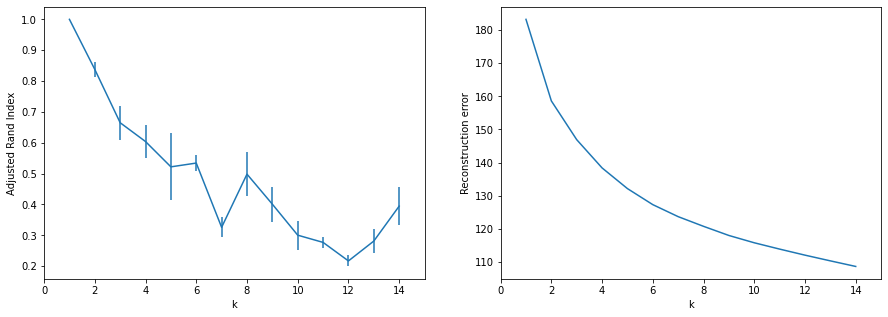

In [512]:
# Plot the similarity.
x = np.arange(k_similarity.shape[0])
y = np.mean(k_similarity,1)
yerr = np.std(k_similarity, axis = 1)/np.sqrt(k_similarity.shape[1])

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].errorbar(x[1:],y[1:], yerr = yerr[1:])

ax[0].set_xlim([0,15])
ax[0].set_xlabel('k')
ax[0].set_ylabel('Adjusted Rand Index')

# Plot the reconstruction error.
x = np.arange(error.shape[0])
ax[1].plot(x[1:],error[1:])

ax[1].set_xlim([0,15])
ax[1].set_xlabel('k')
ax[1].set_ylabel('Reconstruction error')

Plot NMF comopnents and subfields in a common space.

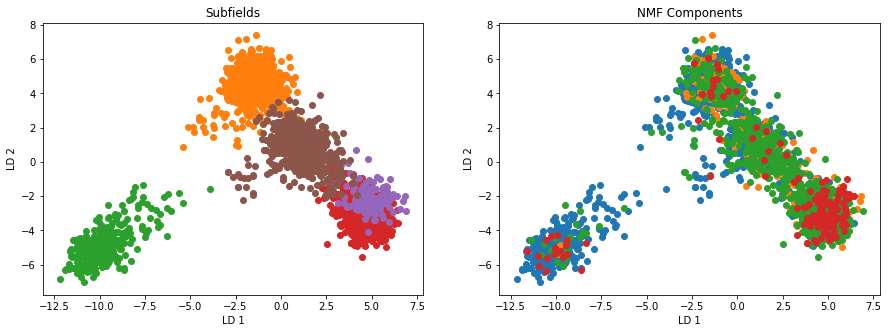

Ajusted Rand-index comparing NMF components and subfields: 0.14183100041687086


In [545]:
# Specify k based on interpretation of plots.
k = 4

# Load subfield labels.
y = pd.read_csv('right_subfield_labels.csv')
y = y.to_numpy()
y = y.reshape(y.shape[0],)

clusters = run_nmf(X,k)[0]

# Get space (1st two linear discriminants).
model = LinearDiscriminantAnalysis(n_components = 2)
model.fit_transform(X,y)
lda_components = model.transform(X)

# Plot Subfields against NMF components in LDA space. 
fig, ax = plt.subplots(1,2,figsize = [15,5])

for k in range(np.max((y,clusters)) + 1):
    ax[0].plot(lda_components[y == k,0], lda_components[y == k,1], marker='o', linestyle='')    
    ax[1].plot(lda_components[clusters == k,0], lda_components[clusters == k,1], marker='o', linestyle='') 

ax[0].set_title('Subfields')
ax[0].set_xlabel('LD 1')
ax[0].set_ylabel('LD 2')

ax[1].set_title('NMF Components')
ax[1].set_xlabel('LD 1')
ax[1].set_ylabel('LD 2')
plt.show()

print('Ajusted Rand-index comparing NMF components and subfields:',adjusted_rand_score(y,clusters))

## Comparison with HCP components identified by Raihann

In [549]:
majority_vote = nib.load('majority_vote_label.nii')
labels = majority_vote.get_fdata()

hcp = nib.load('raihann_warped.nii.gz')

hcp = hcp.get_fdata()
hcp = hcp[labels == 1]
hcp = np.round(hcp)

hcpd = hcpd.astype(int)
hcp = hcp.astype(int)

print('Ajusted Rand-index comparing HCP and HCPD components:',adjusted_rand_score(clusters,hcp))


Ajusted Rand-index comparing HCP and HCPD components: 0.019128005485568287


Plot HCP and HCPD components in a common space.

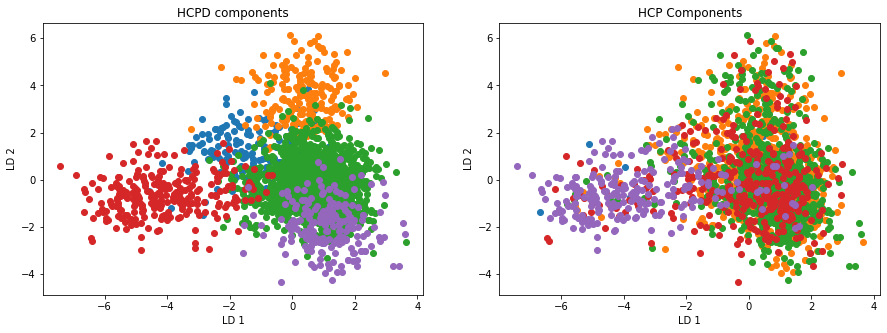

In [550]:

model = LinearDiscriminantAnalysis(n_components = 2)
model.fit_transform(X,hcpd)
lda_components = model.transform(X)

# Plot Subfields against NMF components in LDA space. 
fig, ax = plt.subplots(1,2,figsize = [15,5])

for k in range(5):
    ax[0].plot(lda_components[hcpd == k,0], lda_components[hcpd == k,1], marker = 'o', linestyle = '')    
    ax[1].plot(lda_components[hcp == k,0], lda_components[hcp == k,1], marker = 'o', linestyle = '') 

ax[0].set_title('HCPD components')
ax[0].set_xlabel('LD 1')
ax[0].set_ylabel('LD 2')

ax[1].set_title('HCP Components')
ax[1].set_xlabel('LD 1')
ax[1].set_ylabel('LD 2')
plt.show()

plt.show()

# Partial Least Squares

In [540]:

def get_age(hemisphere):
    Y = pd.read_csv(hemisphere + '_age.csv')
    age = Y['Age'].to_numpy()
    return(age)

def get_X_pls(X,k):
    
    n_subjects = int(X.shape[1]/4)
    
    model = run_nmf(X,k)[1]
    H = model.components_
    
    metric_idx = np.arange(0,n_subjects*4,n_subjects)
    metric_idx = np.append(metric_idx, n_subjects*4)

    X_metric_split = np.split(H,metric_idx, axis = 1)
    X_pls = np.vstack((X_metric_split[1],X_metric_split[2],X_metric_split[3],X_metric_split[4])).T

    return(X_pls)


In [541]:
# Prep data for PLS.
hemisphere = 'right'
k = 5

age = get_age(hemisphere)
X_pls = get_X_pls(load_data(hemisphere),k)


[0.03204373 0.01068601 0.00391977 0.00242673 0.00136432 0.00102278
 0.00042849 0.00080236 0.00085161 0.00046738 0.00151949 0.00113389
 0.00072771 0.00025619 0.00073717]


Text(0, 0.5, 'Component 1 scores')

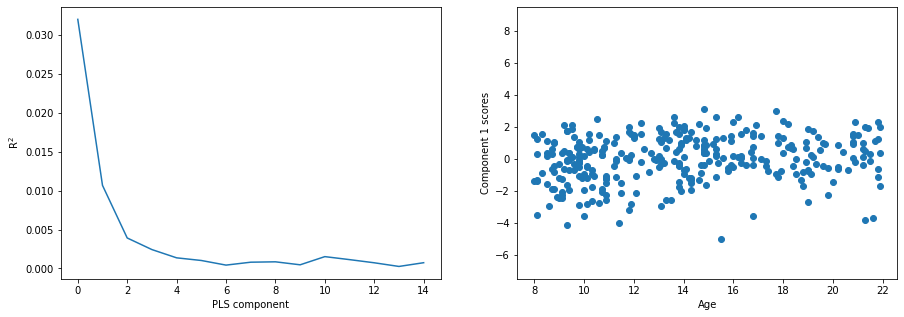

In [520]:
from sklearn.cross_decomposition import PLSRegression

n_comp = 15

model = PLSRegression(n_components=n_comp)
model.fit(X_pls,age)

x_scores = model.x_scores_
x_weights = model.x_weights_

age_corrs = np.zeros(n_comp)
for n in range(n_comp):
    age_corrs[n] = np.corrcoef(x_scores[:,n],age)[0,1]

print(age_corrs**2)

fig, ax = plt.subplots(1,2,figsize = [15,5])

ax[0].plot(age_corrs**2)
ax[0].set_ylabel('R$^2$')
ax[0].set_xlabel('PLS component')

ax[1].plot(age,x_scores[:,0],marker='o', linestyle='')
ax[1].set_ylim(-7.5,9.5)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Component 1 scores')
